<a href="https://colab.research.google.com/github/adit0505/Fetch_SeniorDataAnalyst/blob/main/Fetch_Assessment_Transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Transactions Data

Checking the fields of the Transactions data and seeing if there are any data quality issues

In [32]:
# Importing the Transactions Table for data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_transaction = pd.read_csv('/content/drive/MyDrive/TRANSACTION_TAKEHOME.csv')

## Initial Data Analysis

In [33]:
# Checking the first few rows of the dataset
df_transaction.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


Based on an initial check of the data, the following issues are seen for some rows:


1.  Final Sale is blank
2.	Final Quantity is zero




In [34]:
# Checking the data type of each column
print("\n Data Type")
print(df_transaction.dtypes)

# Checking for missing values in each column
print("\n Missing or Null values in each column")
print(df_transaction.isnull().sum())


 Data Type
RECEIPT_ID         object
PURCHASE_DATE      object
SCAN_DATE          object
STORE_NAME         object
USER_ID            object
BARCODE           float64
FINAL_QUANTITY     object
FINAL_SALE         object
dtype: object

 Missing or Null values in each column
RECEIPT_ID           0
PURCHASE_DATE        0
SCAN_DATE            0
STORE_NAME           0
USER_ID              0
BARCODE           5762
FINAL_QUANTITY       0
FINAL_SALE           0
dtype: int64


Barcode is Null for ~5762 rows in the Transactions data

Checking if the Barcode Null issue is related to a particular Store

In [35]:
# Counting the number of receipts with null BARCODE by store name
receipts_by_store = df_transaction[df_transaction['BARCODE'].isnull()].groupby('STORE_NAME')['RECEIPT_ID'].count().reset_index()
# Sorting the table in descending order of receipt count and limiting to the top 5
top_5_stores = receipts_by_store.sort_values(by='RECEIPT_ID', ascending=False).head(5)

# Renaming columns for better readability
top_5_stores = top_5_stores.rename(columns={'RECEIPT_ID': 'Number of Receipts'})
top_5_stores

,STORE_NAME,Number of Receipts
3,ALDI,2338
45,CVS,606
53,DOLLAR TREE STORES INC,230
107,KROGER,228
200,WALGREENS,226


Out of all the receipts with the Barcode Null issue, ~50% of them are for Aldi.

This needs to be looked into further, blank Barcodes will create an issue for brand level analysis.

## Duplicate Receipt Data Analysis

Checking if the data is unique at the Receipt ID level

In [36]:
# Checking the total number of rows in the table and the number of unique Receipt_IDs
# Checking for unique values in each column
print("\n Unique values in each column")
for col in df_transaction.columns:
  print(col, df_transaction[col].nunique())

total_rows = len(df_transaction)
print("\nTotal number of rows:", total_rows)


 Unique values in each column
RECEIPT_ID 24440
PURCHASE_DATE 89
SCAN_DATE 24440
STORE_NAME 954
USER_ID 17694
BARCODE 11027
FINAL_QUANTITY 87
FINAL_SALE 1435

Total number of rows: 50000


The data is not unique at the Receipt ID level. This makes sense, as one Receipt ID can have multiple Barcodes linked to it.

#### Assumption:
#### The combination of Receipt ID and Barcode should be unique. Based on my understanding of the data, if a product is sold multiple times the Final Quantity field will indicate a number greater than 1.

Checking the above assumption

In [37]:
# Checking the number of unique rows based on a combination of 'RECEIPT_ID' and 'BARCODE'
# Assumption is that each Receipt ID should have a Barcode only once

unique_rows = df_transaction.drop_duplicates(subset=['RECEIPT_ID','BARCODE'])
print("Number of unique rows (Receipt and Barcode combination):", len(unique_rows))
print("Total number of rows:", total_rows)

Number of unique rows (Receipt and Barcode combination): 24795
Total number of rows: 50000


Since the data is not unique at the Receipt ID and Barcode level, checking all instances of the first 5 unique Receipt IDs to understand the data a bit more

In [38]:
# First 5 unique receipt IDs
unique_receipt_ids = df_transaction['RECEIPT_ID'].unique()[:5]

# Filtering to only include rows with those first 5 receipt IDs
filtered_df = df_transaction[df_transaction['RECEIPT_ID'].isin(unique_receipt_ids)]

# Sorting the filtered data to check why this issue is occuring
sorted_df = filtered_df.sort_values(by='RECEIPT_ID')

sorted_df

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
41567,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,1.54
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
39291,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,1.00,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
25928,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,2.54
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
41475,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,1.00,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,
43233,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,5.29


#### Duplicate Receipt ID and Barcode resolution:

Seeing the data, the multiple entries of the Receipt ID and Barcode are linked to the previously seen issue of:

1. Final Sale is blank or
2. Final Volume is zero

**This issue needs to be resolved as it will lead in double counting of sales and receipts when doing the analysis.**

#### Solution:
To resolve this and ensure that each unique combination of Receipt ID and Barcode has only one occurance -> Rows with zero in Total Quantity or blank in Total Sales will be dropped

In [39]:
# Drop rows where 'FINAL_QUANTITY' is zero and 'FINAL_SALE' is blank
df_transaction1 = df_transaction[df_transaction['FINAL_QUANTITY'] != 'zero']
df_transaction2 = df_transaction1[df_transaction1['FINAL_SALE'] != ' ']
df_transaction2.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
25000,7b3ec72d-9d30-40b8-b185-0bfb638942a9,2024-08-20,2024-08-20 11:17:29.633 Z,DOLLAR GENERAL STORE,60fc1e6deb7585430ff52ee7,7.455271e+11,1.00,1.65
25001,04869b68-29e3-4e8d-9bdb-950046fc3473,2024-08-05,2024-08-09 16:06:00.570 Z,DOLLAR GENERAL STORE,654cf234a225ea102b81072e,7.455271e+11,1.00,1.65
25002,f1a96308-24a5-46a8-8d8c-285cf9dce1ba,2024-09-03,2024-09-03 11:28:25.264 Z,WALMART,63c1cb6d3d310dceeac55487,3.700083e+10,1.00,28.22
25003,7ee1798e-fd2e-4278-838b-f417fdcafe08,2024-08-30,2024-09-04 12:53:31.478 Z,DOLLAR GENERAL STORE,65c29b137050d0a6206cd24f,1.200050e+10,1.00,5.25
25004,21feab39-49f2-42e9-ae69-10371e2fc0a9,2024-08-23,2024-08-27 10:45:00.125 Z,TARGET,61a58ac49c135b462ccddd1c,2.400039e+10,1.00,2.59


Checking if the issue is fixed

In [40]:
# First 5 unique receipt IDs
unique_receipt_ids1 = df_transaction2['RECEIPT_ID'].unique()[:5]

# Filtering to only include rows with those first 5 receipt IDs
filtered_df1 = df_transaction2[df_transaction2['RECEIPT_ID'].isin(unique_receipt_ids1)]

# Sorting the filtered data to check why this issue is occuring
sorted_df1 = filtered_df1.sort_values(by='RECEIPT_ID')

sorted_df1

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
25001,04869b68-29e3-4e8d-9bdb-950046fc3473,2024-08-05,2024-08-09 16:06:00.570 Z,DOLLAR GENERAL STORE,654cf234a225ea102b81072e,7.455271e+11,1.00,1.65
25004,21feab39-49f2-42e9-ae69-10371e2fc0a9,2024-08-23,2024-08-27 10:45:00.125 Z,TARGET,61a58ac49c135b462ccddd1c,2.400039e+10,1.00,2.59
25000,7b3ec72d-9d30-40b8-b185-0bfb638942a9,2024-08-20,2024-08-20 11:17:29.633 Z,DOLLAR GENERAL STORE,60fc1e6deb7585430ff52ee7,7.455271e+11,1.00,1.65
25003,7ee1798e-fd2e-4278-838b-f417fdcafe08,2024-08-30,2024-09-04 12:53:31.478 Z,DOLLAR GENERAL STORE,65c29b137050d0a6206cd24f,1.200050e+10,1.00,5.25
25002,f1a96308-24a5-46a8-8d8c-285cf9dce1ba,2024-09-03,2024-09-03 11:28:25.264 Z,WALMART,63c1cb6d3d310dceeac55487,3.700083e+10,1.00,28.22
41288,f1a96308-24a5-46a8-8d8c-285cf9dce1ba,2024-09-03,2024-09-03 11:28:25.264 Z,WALMART,63c1cb6d3d310dceeac55487,8.307800e+10,1.00,5.94


After performing the above changes, it is important to see that all combinations of Receipt ID and Barcode are still present in the data

In [41]:
# Creating a unique combination of Receipt ID and Barcode from both data sets (Transactions and Products)
# The data from Transactions is updated by dropping rows with zero as Final_Quantity and Null as Final_Sale

# Replacing NaN and '' with a unique identifier (e.g., 'MISSING_BARCODE')
unique_combinations_df = set(zip(df_transaction['RECEIPT_ID'], df_transaction['BARCODE'].fillna('MISSING_BARCODE').replace(' ', 'MISSING_BARCODE')))

# Replacing NaN and '' with the same unique identifier
unique_combinations_df1 = set(zip(df_transaction2['RECEIPT_ID'], df_transaction2['BARCODE'].fillna('MISSING_BARCODE').replace(' ', 'MISSING_BARCODE')))

# Check if all combinations from df (Transactions data) are present in df1 (Products data)
all_present = unique_combinations_df.issubset(unique_combinations_df1)

print("All unique combinations from Transactions data are present in Products data:", all_present)

All unique combinations from Transactions data are present in Products data: True


All the combinations of Receipt ID and Barcode are still present, that means there was no data loss.

## User Analysis

Checking if all the users in the Transaction data are present in the User data as well

In [53]:
df_user = pd.read_csv('/content/drive/MyDrive/USER_TAKEHOME.csv')

In [65]:
# Checking if all USER_ID from df_transaction are present in the ID column of df_user
missing_user_ids = set(df_transaction['USER_ID']) - set(df_user['ID'])

df_missing_users = pd.DataFrame({'USER_ID': list(missing_user_ids)})

# Printing the number of USER_IDs not present
print("Number of USER_IDs not present in df_user:", len(missing_user_ids))

mapped_user_ids = df_transaction['USER_ID'].nunique() - len(missing_user_ids)
print("Number of Transaction USER_IDs mapped to User data:", (len(missing_user_ids)/df_transaction['USER_ID'].nunique())*100)


Number of USER_IDs not present in df_user: 17603
Number of Transaction USER_IDs mapped to User data: 99.48570136769527


This will impact the analysis severely, as any user level analysis will not be usable as only ~0.5% of users in the Transaction data were mapped to the User data.

### Hence, we will only be able to get user data for these ~0.5% of users

## Barcode Analysis

Premliminary checks to see the barcodes in the Transactions and Products table


1.   Length of Barcodes in each table
2.   Checking the Barcodes from Transactions table that are present in the Products table




In [42]:
df_products = pd.read_csv('/content/drive/MyDrive/PRODUCTS_TAKEHOME.csv')

In [43]:
df_transaction3 = df_transaction2.copy()  # Create a copy of df_transaction2
df_transaction3['BARCODE'] = df_transaction3['BARCODE'].apply(lambda x: str(int(x)) if pd.notna(x) else '')

In [44]:
df_transaction3.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
25000,7b3ec72d-9d30-40b8-b185-0bfb638942a9,2024-08-20,2024-08-20 11:17:29.633 Z,DOLLAR GENERAL STORE,60fc1e6deb7585430ff52ee7,745527114884,1.00,1.65
25001,04869b68-29e3-4e8d-9bdb-950046fc3473,2024-08-05,2024-08-09 16:06:00.570 Z,DOLLAR GENERAL STORE,654cf234a225ea102b81072e,745527114884,1.00,1.65
25002,f1a96308-24a5-46a8-8d8c-285cf9dce1ba,2024-09-03,2024-09-03 11:28:25.264 Z,WALMART,63c1cb6d3d310dceeac55487,37000828761,1.00,28.22
25003,7ee1798e-fd2e-4278-838b-f417fdcafe08,2024-08-30,2024-09-04 12:53:31.478 Z,DOLLAR GENERAL STORE,65c29b137050d0a6206cd24f,12000504051,1.00,5.25
25004,21feab39-49f2-42e9-ae69-10371e2fc0a9,2024-08-23,2024-08-27 10:45:00.125 Z,TARGET,61a58ac49c135b462ccddd1c,24000393429,1.00,2.59


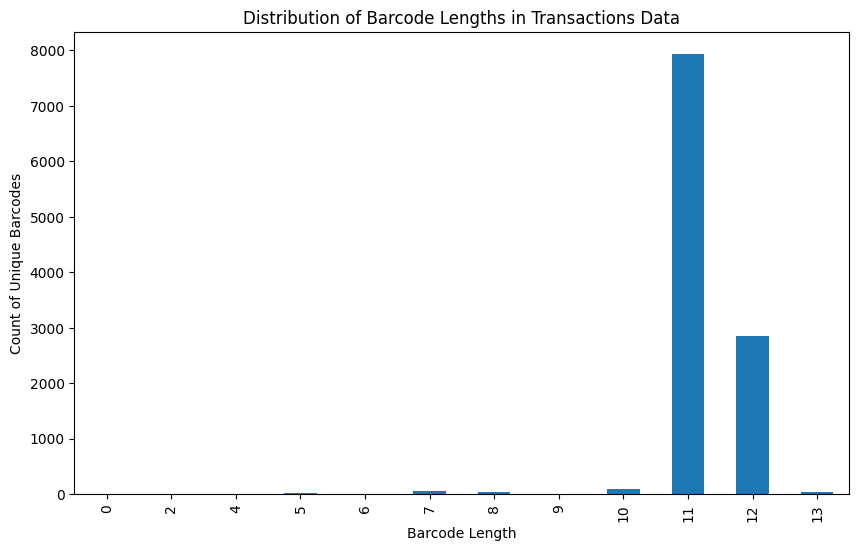

In [45]:
# Calculate barcode lengths
df_transaction3['barcode_length'] = df_transaction3['BARCODE'].astype(str).str.len()

# Get unique barcodes
unique_barcodes = df_transaction3.drop_duplicates(subset=['BARCODE'])

# Group by barcode length and count unique barcodes
barcode_length_counts = unique_barcodes.groupby('barcode_length')['BARCODE'].count()

# Create the plot
plt.figure(figsize=(10, 6))
barcode_length_counts.plot(kind='bar')
plt.xlabel('Barcode Length')
plt.ylabel('Count of Unique Barcodes')
plt.title('Distribution of Barcode Lengths in Transactions Data')
plt.show()

In [46]:
df_products1 = df_products.copy()  # Create a copy of df_transaction2
df_products1['BARCODE'] = df_products1['BARCODE'].apply(lambda x: str(int(x)) if pd.notna(x) else '')

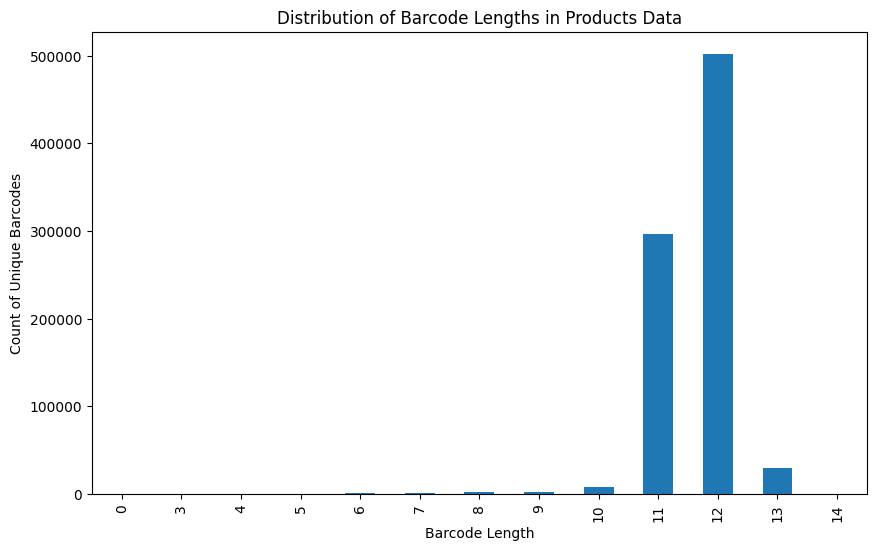

In [47]:
# Calculate barcode lengths
df_products1['barcode_length'] = df_products1['BARCODE'].astype(str).str.len()

# Get unique barcodes
unique_barcodes1 = df_products1.drop_duplicates(subset=['BARCODE'])

# Group by barcode length and count unique barcodes
barcode_length_counts1 = unique_barcodes1.groupby('barcode_length')['BARCODE'].count()

# Create the plot
plt.figure(figsize=(10, 6))
barcode_length_counts1.plot(kind='bar')
plt.xlabel('Barcode Length')
plt.ylabel('Count of Unique Barcodes')
plt.title('Distribution of Barcode Lengths in Products Data')
plt.show()

We can see that barcodes are of various lengths across both files, this issue may be due to the data type of the BARCODE field.

BARCODE data type is float64 in the Transactions table and hence there is a data loss caused by first digit(s) being 0.

### Assumption

#### All barcodes are of the same length

To ensure that there are no data misses in the analysis, checking the number of Transaction Barcodes not being mapped to the Product Barcodes

### Solution

1.   #### Creating a standard Barcode length of 14 digits (as that is the max in Products table)
2.   #### Converting the Barcode to a str to avoid data loss



In [48]:
def convert_barcode(barcode):
  barcode = str(barcode)
  return barcode.zfill(14)

df_transaction3['BARCODE'] = df_transaction3['BARCODE'].apply(convert_barcode)
df_products1['BARCODE'] = df_products1['BARCODE'].apply(convert_barcode)

In [49]:
df_transaction3.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,barcode_length
25000,7b3ec72d-9d30-40b8-b185-0bfb638942a9,2024-08-20,2024-08-20 11:17:29.633 Z,DOLLAR GENERAL STORE,60fc1e6deb7585430ff52ee7,00745527114884,1.00,1.65,12
25001,04869b68-29e3-4e8d-9bdb-950046fc3473,2024-08-05,2024-08-09 16:06:00.570 Z,DOLLAR GENERAL STORE,654cf234a225ea102b81072e,00745527114884,1.00,1.65,12
25002,f1a96308-24a5-46a8-8d8c-285cf9dce1ba,2024-09-03,2024-09-03 11:28:25.264 Z,WALMART,63c1cb6d3d310dceeac55487,00037000828761,1.00,28.22,11
25003,7ee1798e-fd2e-4278-838b-f417fdcafe08,2024-08-30,2024-09-04 12:53:31.478 Z,DOLLAR GENERAL STORE,65c29b137050d0a6206cd24f,00012000504051,1.00,5.25,11
25004,21feab39-49f2-42e9-ae69-10371e2fc0a9,2024-08-23,2024-08-27 10:45:00.125 Z,TARGET,61a58ac49c135b462ccddd1c,00024000393429,1.00,2.59,11


In [50]:
unique_barcodes_transactions = set(df_transaction3['BARCODE'].dropna().unique())
unique_barcodes_products = set(df_products1['BARCODE'].dropna().unique())

common_barcodes = unique_barcodes_transactions.intersection(unique_barcodes_products)

print(f"Number of unique Transaction table barcodes present in the Products table: {len(common_barcodes)}")
print(f"% of unique Transaction table barcodes present in the Products table: {(len(common_barcodes)/len(unique_barcodes_transactions))*100}%")

Number of unique Transaction table barcodes present in the Products table: 6563
% of unique Transaction table barcodes present in the Products table: 59.51215088864708%


This will present a challenge in the analysis as ~41% of the unique barcodes
present in the Transactions table will not be mapped to the Products table, hence we cannot generate any summaries for them.

We need to get better mapping for barcodes between the Transactions and Products data, to ensure that we can accurately perform brand or category level analysis.

## Exporting the updated Transaction and Product data into a csv file for data analysis in SQL later.

### Updates for Transaction Data:
1. Dropping receipts with zero Final Quantity and blank Final Sale
2. Converting Barcode into a string of length 14

### Updates for Product Data:
1. Converting Barcode into a string of length 14

In [51]:
df_transaction3.to_csv("Transactions_Updated.csv", index=False)
from google.colab import files
files.download("Transactions_Updated.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
df_products1.to_csv("Products_Updated.csv", index=False)
from google.colab import files
files.download("Products_Updated.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>